In [1]:
import pandas as pd

In [2]:
PATH = 'data/d.csv'

In [3]:
csv = pd.read_csv(PATH)

In [4]:
csv

,plant.ID,y,alpha
0,1,0,-4.159582
1,2,0,-3.718362
2,3,0,-3.069020
3,4,0,-3.054211
4,5,0,-2.880656
5,6,2,-2.705595
6,7,1,-2.441703
7,8,1,-2.221327
8,9,0,-2.209120
9,10,1,-2.111941


In [5]:
ys = csv['y'].values

In [6]:
import numpy as np

histo_ys = np.zeros(11)
for y in ys:
    histo_ys[y] += 1
print(histo_ys)
print(np.sum(histo_ys))

[  7.  10.  10.   5.  12.  11.  11.   7.  14.   9.   4.]
100.0


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

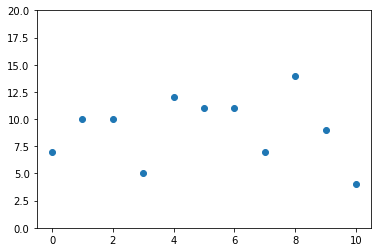

In [8]:
xs = np.arange(11)
plt.scatter(xs, histo_ys)
plt.ylim(0, 20)
plt.show()

In [9]:
import pymc3 as pm

In [10]:
ys

array([ 0,  0,  0,  0,  0,  2,  1,  1,  0,  1,  2,  2,  1,  1,  4,  1,  1,
        1,  1,  2,  4,  2,  2,  6,  2,  3,  0,  3,  6,  5,  2,  4,  1,  5,
        5,  3,  4,  4,  3,  5,  2,  3,  5,  6,  4,  4,  5,  2,  6,  6,  8,
        4,  6,  5,  5,  7,  4,  6,  4,  5,  5,  4,  6,  7,  4,  5,  6, 10,
        9, 10,  8,  7,  8,  6,  8,  8,  8,  9,  9,  8,  9,  7,  8,  7,  7,
        8,  8,  9,  8,  9,  9,  9,  8,  7,  6,  8,  8,  9, 10, 10])

In [11]:
model = pm.Model()
with model:
    q = pm.Uniform('q', lower=0, upper=1)
    y = pm.Binomial('y', n=10, p=q, observed=ys)
    map_estimate = pm.find_MAP(model=model)

logp = -316.78, ||grad|| = 4: 100%|██████████| 5/5 [00:00<00:00, 56.59it/s]


In [12]:
print((float(map_estimate['q'])))

0.4960000053023121


In [13]:
import scipy

In [14]:
rv = scipy.stats.binom(10, map_estimate['q'])
binom_ys = [100 * rv.pmf(k) for k in range(11)]

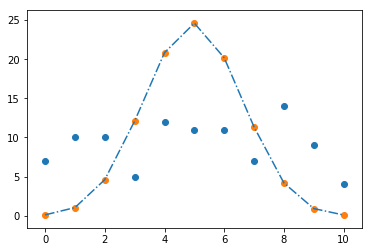

In [15]:
plt.scatter(xs, histo_ys)
plt.plot(xs, binom_ys, ls='-.')
plt.scatter(xs, binom_ys)
plt.show()

In [16]:
model = pm.Model()
with model:
    beta = pm.Normal('beta', mu=0, tau=1.0e-2)
    tau = pm.Gamma('tau', alpha=1.0e-02, beta=1.0e-02)
    alpha = pm.Normal('alpha', mu=0, tau=tau , shape=len(ys))
    ymu = pm.math.sigmoid(beta + alpha)
    y = pm.Binomial('y', n=10, p=ymu, observed=ys)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(5000, start=start, step=step)
alpha.shape

logp = -48.984, ||grad|| = 0.031497: 100%|██████████| 33/33 [00:00<00:00, 1701.29it/s]  
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, tau, beta]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:24<00:00, 282.45draws/s] 


Shape.0

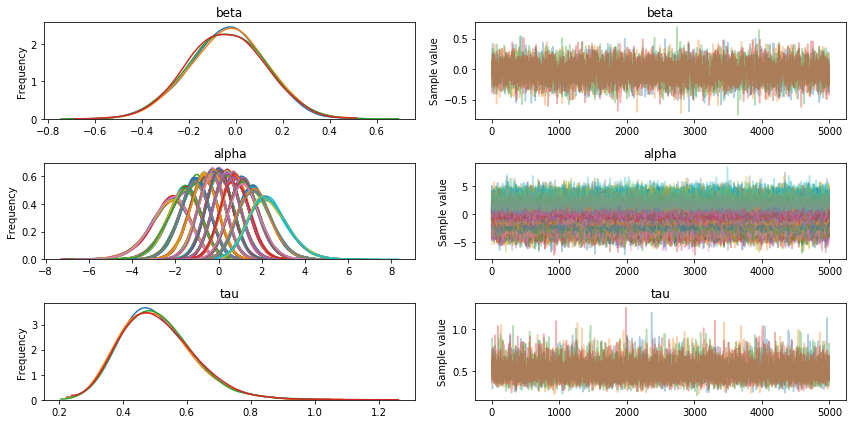

In [17]:
pm.traceplot(trace)
plt.figure(figsize=(10, 20))
plt.show()

In [18]:
beta_samples = trace['beta'][:]
print(beta_samples.shape)
beta_samples = beta_samples.reshape(-1, 1)
print(beta_samples.shape)

(20000,)
(20000, 1)


In [19]:
alpha_samples = trace['alpha'][:]
alpha_samples.shape

(20000, 100)

In [20]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [21]:
q_samples = sigmoid(beta_samples + alpha_samples)
q_samples.shape

(20000, 100)

In [22]:
mean_q = q_samples.mean(axis=0)
print(mean_q.shape)
mean_q


(100,)


array([ 0.11409394,  0.11481868,  0.1138471 ,  0.11426514,  0.11469664,
        0.25748295,  0.1807536 ,  0.18230779,  0.11529389,  0.18261732,
        0.25704021,  0.25735139,  0.18240601,  0.18207556,  0.41666163,
        0.18249042,  0.18188879,  0.18217002,  0.18135551,  0.25770069,
        0.41462573,  0.25646023,  0.25882122,  0.58033204,  0.25647874,
        0.33576058,  0.11386914,  0.33508483,  0.57806416,  0.49785714,
        0.25767741,  0.41664706,  0.18182947,  0.49704436,  0.49812984,
        0.33511615,  0.41712018,  0.41628313,  0.33519632,  0.49786802,
        0.2568635 ,  0.33603019,  0.49961689,  0.57920413,  0.41629894,
        0.41783119,  0.49909925,  0.25705983,  0.57982676,  0.58063941,
        0.73999619,  0.41488046,  0.58044314,  0.49750541,  0.49787156,
        0.66109013,  0.41691442,  0.580699  ,  0.41717873,  0.49896279,
        0.50042359,  0.41616326,  0.57880762,  0.66098165,  0.41838319,
        0.49829696,  0.57976155,  0.88320399,  0.81530958,  0.88

In [23]:
rows, = mean_q.shape
rows

100

In [34]:
y_samples = np.empty((100, 11))
for i in range(rows):
    rv = scipy.stats.binom(10, mean_q[i])
    y_samples[i] = [rv.pmf(k) for k in range(11)]
pred_y = np.sum(y_samples, axis=0)
print(pred_y.shape)

(11,)


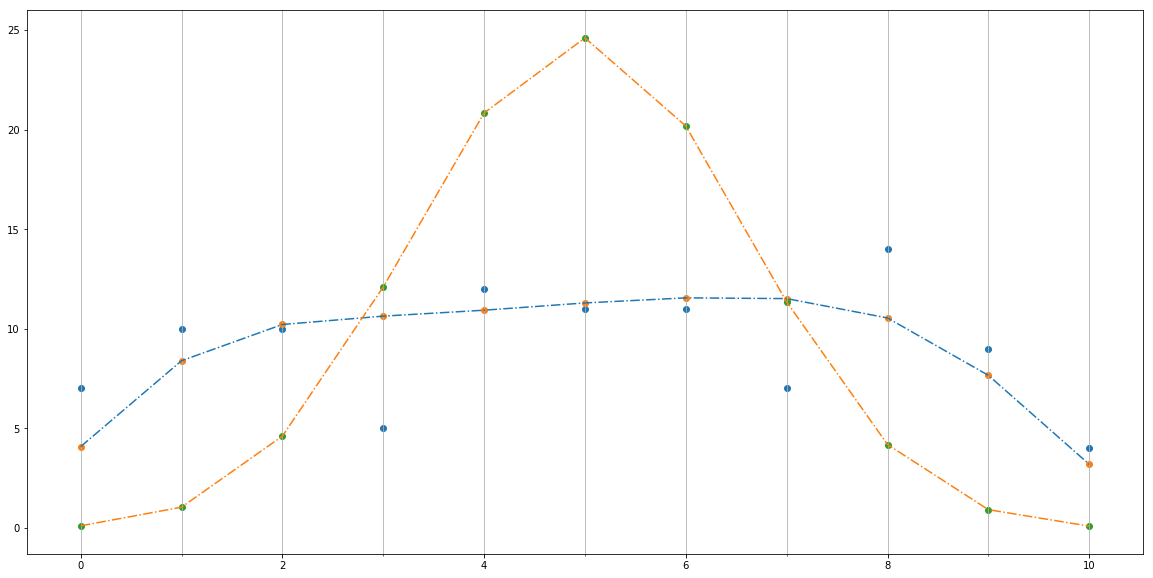

In [35]:
import matplotlib.ticker as tick
plt.figure(figsize=(20,10))
plt.scatter(xs, histo_ys)
plt.plot(xs, pred_y, ls='-.')
plt.scatter(xs, pred_y)
plt.plot(xs, binom_ys, ls='-.')
plt.scatter(xs, binom_ys)
plt.gca().xaxis.set_minor_locator(tick.MultipleLocator(1))
plt.grid(which='minor')
# plt.legend(loc='best')
plt.show()

In [36]:
std_q = q_samples.std(axis=0)
print(std_q.shape)
std_q

(100,)


array([ 0.08167299,  0.08246446,  0.0802434 ,  0.08026631,  0.08136697,
        0.11820848,  0.10108444,  0.10349863,  0.0826521 ,  0.10166113,
        0.11879655,  0.11846152,  0.10167755,  0.10300832,  0.13749787,
        0.10362824,  0.10239014,  0.10228263,  0.10214106,  0.11923828,
        0.13536396,  0.11887826,  0.11928665,  0.13589087,  0.11869434,
        0.13007528,  0.08110203,  0.12977194,  0.13631489,  0.13887582,
        0.11798187,  0.13675952,  0.10158995,  0.13739829,  0.13753479,
        0.1296657 ,  0.13526408,  0.13677386,  0.12851205,  0.13931228,
        0.11677784,  0.13130811,  0.13761929,  0.13682928,  0.13557898,
        0.13689268,  0.1376046 ,  0.11928928,  0.13628572,  0.13561332,
        0.11715292,  0.13547167,  0.13692556,  0.13838862,  0.13859864,
        0.13000276,  0.13697693,  0.13576257,  0.13616978,  0.1377736 ,
        0.13723621,  0.13560599,  0.13603149,  0.13082717,  0.13510115,
        0.13670604,  0.13515312,  0.08123142,  0.1038765 ,  0.08

In [37]:
yp_samples = np.empty((100, 11))
ym_samples = np.empty((100, 11))
for i in range(rows):
    prv = scipy.stats.binom(10, std_q[i] + mean_q[i])
    yp_samples[i] = [prv.pmf(k) for k in range(11)]
    mrv = scipy.stats.binom(10, -std_q[i] + mean_q[i])
    ym_samples[i] = [mrv.pmf(k) for k in range(11)]

pred_py = np.sum(yp_samples, axis=0)
pred_my = np.sum(ym_samples, axis=0)

print(pred_y.shape)

(11,)


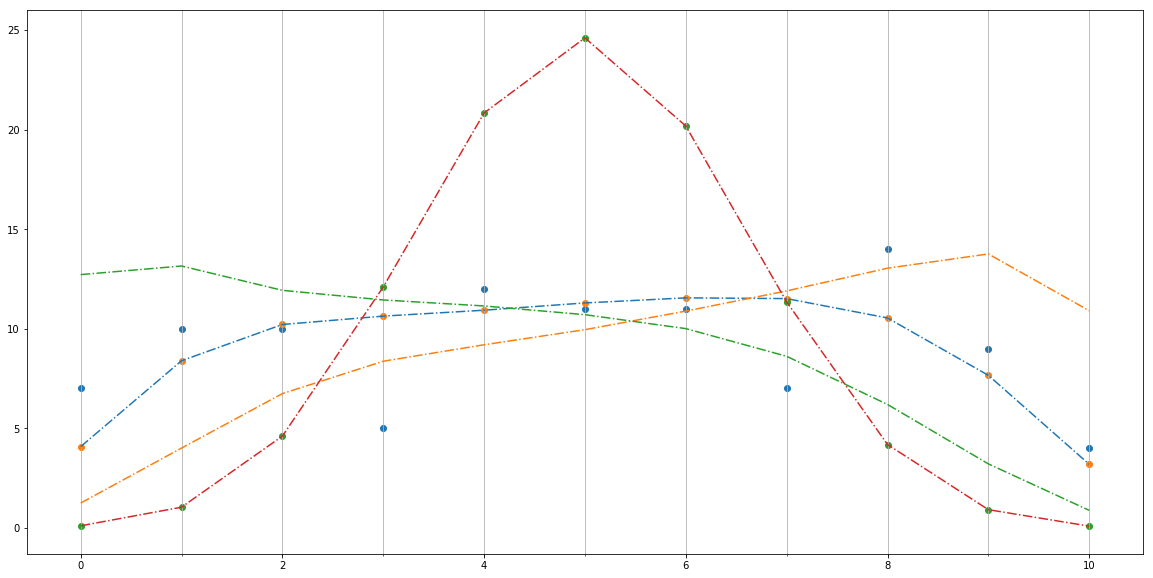

In [38]:
plt.figure(figsize=(20,10))
plt.scatter(xs, histo_ys)
plt.plot(xs, pred_y, ls='-.')
plt.plot(xs, pred_py, ls='-.')
plt.plot(xs, pred_my, ls='-.')
plt.scatter(xs, pred_y)
plt.plot(xs, binom_ys, ls='-.')
plt.scatter(xs, binom_ys)
plt.gca().xaxis.set_minor_locator(tick.MultipleLocator(1))
plt.grid(which='minor')
# plt.legend(loc='best')
plt.show()